## 📥 Fetch data

We'll fetch contents from VS Code docs ([GitHub repo](https://github.com/microsoft/vscode-docs/blob/main)) and save it into a json format that can be used for RAG models.

In [1]:
# Recursively fetch all md files from a GH repo using gh api

import os
import requests
from dotenv import load_dotenv

load_dotenv()

REPO_OWNER = 'microsoft'
REPO_NAME = 'vscode-docs'

def get_markdown_files_from_github(path=''):
    url = f'https://api.github.com/repos/{REPO_OWNER}/{REPO_NAME}/contents/{path}'
    headers = {
        'Authorization': f'token {os.getenv("GITHUB_TOKEN")}'
    }
    response = requests.get(url, headers=headers)
    markdown_files = []

    if response.status_code == 200:
        files = response.json()

        for file in files:
            if file['type'] == 'dir':
                markdown_files += get_markdown_files_from_github(file['path'])
            elif file['type'] == 'file' and file['name'].endswith('.md'):
                markdown_files.append(file['path'])

        return markdown_files
    else:
        raise Exception(f"Error fetching repo contents: {response.status_code}")
    
# Test: Print all markdown files in the learn/students folder
print(get_markdown_files_from_github("learn/students"))

['learn/students/github-pack.md', 'learn/students/nasa-python.md', 'learn/students/over-the-moon-python.md', 'learn/students/spacejam-python.md', 'learn/students/wonder-woman-python.md']


In [2]:
# Get the content of a file using gh api

import base64

def get_file_content(file_path):
    url = f'https://api.github.com/repos/{REPO_OWNER}/{REPO_NAME}/contents/{file_path}'
    headers = {
        'Authorization': f'token {os.getenv("GITHUB_TOKEN")}'
    }
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        file_content = base64.b64decode(response.json()['content']).decode('utf-8')
        title = next(line.replace('# ', '') for line in file_content.split('\n') if line.startswith('#'))
        description = next((line.split(':', 1)[1].strip() for line in file_content.split('\n') if line.lower().startswith('metadescription:')), '')
        content = file_content.split(title, 1)[1].strip()
        content = content.replace('<!-- DOWNLOAD_LINKS_PLACEHOLDER -->', '')
        full_content = f"{description}\n\n{content}"
        return {
            'content': full_content, # rate limit could be exceeded for free tier
            'url': f'https://github.com/{REPO_OWNER}/{REPO_NAME}/blob/main/{file_path}',
        }
    else:
        raise Exception(f"Error fetching file content: {response.status_code}")
    
# Test: Print a sample file content
get_file_content("release-notes/v1_94.md")

{'content': 'Learn what is new in the Visual Studio Code September 2024 Release (1.94)\n\n**Update 1.94.1**: The update addresses this security [issue](https://github.com/microsoft/vscode/issues?q=is%3Aissue+is%3Aclosed+milestone%3A%22September+2024+Recovery+1%22+).\n\n**Update 1.94.2**: The update addresses these [issues](https://github.com/microsoft/vscode/issues?q=is%3Aissue+milestone%3A%22September+2024+Recovery+2%22+is%3Aclosed).\n\n\n\n---\n\nWelcome to the September 2024 release of Visual Studio Code. There are many updates in this version that we hope you\'ll like, some of the key highlights include:\n\n* [Find in Explorer](#find-in-explorer) - Quickly find files in the Explorer view with the improved Find control.\n* [Source Control Graph](#source-control) - More filtering options and interactivity in the Source Control Graph.\n* [Python test coverage](#python) - Run Python tests with coverage and get rich results in the editor.\n* [ESM](#esm-is-shipping-for-vs-code) - Faster 

In [4]:
# Iterate over each file in `release-notes` and get the content

docs_files = get_markdown_files_from_github("release-notes")

docs_contents = []
for file_path in docs_files:
    content = get_file_content(file_path)
    docs_contents.append(content)

# Print the first few contents to verify
for doc in docs_contents[:5]:
    print(doc)

{'content': 'See what is new in the Visual Studio Code July 2016 Release (1.4)\n\nDuring July, we slowed down feature work in favor of reducing our bug backlog and removing engineering debt. However, we were still able to add some improvements.\n\nHere are the highlights:\n\n* **Workbench**: Editor actions such as **Open Preview** and **Switch to Changes View** are back on the title bar. IME and Copy/Paste support in the Integrated Terminal.\n* **Editor**: Better snippet and suggestions control. New **Insert Snippet** command with dedicated UI.\n* **Debugging**: **Restart Frame** action to rerun a specific stack frame.  \'Variable paging\' feature moved into VS Code and available to all debug extensions.\n* **Extension Authoring**: New \'move\' commands to better support VIM gestures. Custom link behavior with the `DocumentLinkProvider` API. Expanded Debug Protocol.\n\nDownloads: [Windows](https://az764295.vo.msecnd.net/stable/6276dcb0ae497766056b4c09ea75be1d76a8b679/VSCodeSetup-stable

## 🧩 Chunk data

Creating embeddings now will help us to conduct semantic search much faster later on. But before we embed the release notes data into the RAG model, we need to chunk the data so that it can fit into the embeddings model. For our exploration, we're going to use OpenAI's Text Embedding 3 (small) model -- which has a limit of ~8k tokens.

In [12]:
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3")
]

In [19]:
import json
import re
from langchain.text_splitter import MarkdownHeaderTextSplitter

gh_link = r'https://github\.com/microsoft/vscode-docs/blob/main/release-notes/(.+)\.md'
docs_link = r'https://code.visualstudio.com/updates/\1'

# MD splits
markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)

# Split
splits = []
for page in docs_contents:
    markdown_document = page['content']
    page_splits = markdown_splitter.split_text(markdown_document)
    for split in page_splits:
        if 'Header 3' in split.metadata:
            split.page_content = page_splits[0].page_content.split('\n', 1)[0] + '\n' + split.page_content
            url = re.sub(gh_link, docs_link, page['url'])
            header_text = split.metadata['Header 3'].replace(' ', '_')
            split.metadata['url'] = f"{url}#{header_text}"
            splits.append(split)
splits

[Document(page_content='See what is new in the Visual Studio Code July 2016 Release (1.4)  \nBy default, VS Code shows snippets and completion proposals in one widget. This is not always desirable so we added a new configuration setting called `editor.snippetSuggestions`. To remove snippets from the suggestions widget, set the value to `"none"`. If you\'d like to see snippets, you can specify the order relative to suggestions; at the top (`"top"`), at the bottom (`"bottom`"), or inline ordered alphabetically (`"inline"`). The default is `"inline"`.  \nIn addition, we added a new command to insert a snippet, **Insert Snippet**, which displays the available snippets in a dropdown.  \n![snippet insert](images/July_2016/insertSnippet.gif)', metadata={'Header 2': 'Editor', 'Header 3': 'Snippets and Suggestions', 'url': 'https://code.visualstudio.com/updates/July_2016#Snippets_and_Suggestions'}),
 Document(page_content='See what is new in the Visual Studio Code July 2016 Release (1.4)  \nThe

In [14]:
import re

def url_cleaner(text):
    text = text.lower()
    text = text.replace(" ", "-")
    text = text.replace('"', '')
    text = text.replace('`', '')
    text = re.sub(r'[()]+', '', text)
    return text

# Test: Print a sample converted text
print(url_cleaner("A sample TEXT (with \"special\" `char`acters)"))

a-sample-text-with-special-characters


In [20]:
for split in splits:
    if 'metadata' in split and 'url' in split.metadata:
        split.metadata['url'] = url_cleaner(split.metadata['url'])

# Print the first few splits to verify
for split in splits[:5]:
    print(split)
    print('---')

page_content='See what is new in the Visual Studio Code July 2016 Release (1.4)  \nBy default, VS Code shows snippets and completion proposals in one widget. This is not always desirable so we added a new configuration setting called `editor.snippetSuggestions`. To remove snippets from the suggestions widget, set the value to `"none"`. If you\'d like to see snippets, you can specify the order relative to suggestions; at the top (`"top"`), at the bottom (`"bottom`"), or inline ordered alphabetically (`"inline"`). The default is `"inline"`.  \nIn addition, we added a new command to insert a snippet, **Insert Snippet**, which displays the available snippets in a dropdown.  \n![snippet insert](images/July_2016/insertSnippet.gif)' metadata={'Header 2': 'Editor', 'Header 3': 'Snippets and Suggestions', 'url': 'https://code.visualstudio.com/updates/July_2016#Snippets_and_Suggestions'}
---
page_content='See what is new in the Visual Studio Code July 2016 Release (1.4)  \nThe editor now support

## 🔢 Calculate embeddings

Now let's generate embeddings for the chunks as these will help us to conduct semantic search. There are two ways to do this: we could use an embeddings model from

1. [GitHub Models](https://github.com/marketplace/models/azure-openai/text-embedding-3-small), or
2. [Azure AI Studio](https://oai.azure.com/portal) by deploying the model through the studio.

GitHub Models does have [rate limits](https://docs.github.com/en/github-models/prototyping-with-ai-models#rate-limits) as can seen below. So I've used Azure AI Studio instead, which provides pay-as-you-go pricing and no rate limits.

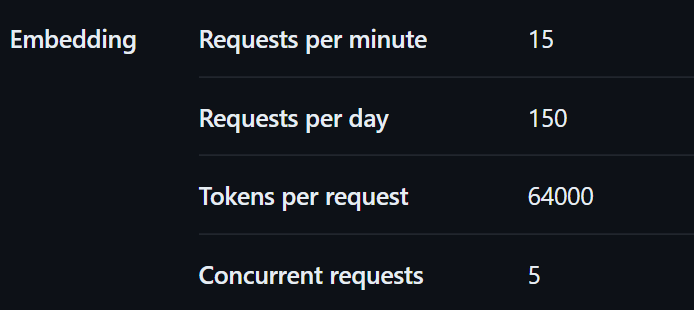

In [39]:
# Create embeddings using Azure OpenAI SDK - DO NOT RUN, TAKES TOO LONG TO DEMO LIVE

import os
import openai
from dotenv import load_dotenv

load_dotenv()

def generate_azure_embedding(text):
    client = openai.AzureOpenAI(
        azure_endpoint="https://sominverse.openai.azure.com/openai/deployments/text-embedding-3-small/embeddings?api-version=2023-05-15",
        api_key=os.getenv("AZURE_AI_TOKEN"),
        api_version="2023-05-15"
    )

    response = client.embeddings.create(
        model="text-embedding-3-small",
        input=text
    )

    embeddings = response.data[0].embedding
    return embeddings

# Generate embeddings
for item in splits:
    if 'content' in item:
        item['content_embeddings'] = generate_azure_embedding(item['content'])
    else:
        splits.remove(item)

# Add id to each item
for idx, item in enumerate(splits):
    item['id'] = idx

In [40]:
for split in splits[:5]:
    print(split)
    print('---')

{'content': "Learn what is new in the Visual Studio Code May 2022 Release (1.68)  \n#### No interpreter discovery at startup  \nThe [Python](https://marketplace.visualstudio.com/items?itemName=ms-python.python) extension now auto-triggers discovery only when:  \n* Using **Python: Select Interpreter** command to choose a different interpreter.\n* A particular scope (workspace or global) is opened for the first time.\n* No Python is installed.  \nSince discovery isn't triggered automatically at startup, this leads to instantaneous load, and faster startup of other features like the language server. However, if the [Jupyter](https://marketplace.visualstudio.com/itemdetails?itemName=ms-toolsai.jupyter) extension is installed/enabled, discovery is still triggered by Jupyter at startup.  \n#### Enable localization  \nThe Python extension now supports translations in all the languages that VS Code supports. We have updated the way we get the translations of our commands, notifications, titles

In [41]:
import json

with open('release_notes_w_embeddings.json', 'w') as file:
    json.dump(splits, file, indent=2)